# Solving PDEs with Jax - Problem 8
## Description

### Average time of execution 
Between 4 and 5 minutes on GPU

### PDE
We will try to solve the problem 8 of the article https://ieeexplore.ieee.org/document/712178  

$\Delta \psi(x,y) +\psi(x,y)\cdot\frac{\partial \psi(x,y)}{\partial y}= f(x,y)$ on $\Omega = [0,1]^2$  
where $f(x, y)=\sin(\pi x)(2-\pi^2y^2+2y^3\sin(\pi x))$   

### Boundary conditions    
$\psi(0,y)=\psi(1,y)=\psi(x,0)=0$ and $\frac{\partial \psi}{\partial y}(x,1)=2\sin(\pi x)$           

### Analytical solution
The analytical solution is $\psi(x, y)=y^2sin(\pi x)$  

### Approximated solution
We want to find a approximated solution $\psi_{a}(x, y)=N(x, y)$ such that described in the second Lagaris's paper

### Loss function
The loss to minimize here is $\mathcal{L} = \frac{1}{N}||\Delta \psi(x,y) +\psi(x,y)\cdot\frac{\partial \psi(x,y)}{\partial y}-f(x,y) ||_2 + \frac{1}{M}\eta||\psi_{a}|_{\partial \Omega}-b||_2^2$, 


where N and M are the size of the training data inside the domain and boundary. $b$ is the value of each point at the boundary

# Libraries

In [1]:
import jax, optax
import pickle
import functools
import matplotlib.pyplot
import numpy
import utils
%matplotlib inline

# Set and verify device
jax.config.update('jax_platform_name', 'gpu')
jax.config.update("jax_enable_x64", True)
#jax.config.update("jax_disable_jit", True)
print(jax.lib.xla_bridge.get_backend().platform)

gpu


# Parameters

In [2]:
# Neural network parameters
parameters = {}
parameters['seed'] = 351
parameters['n_features'] = 2        # Input dimension (x1, x2)
parameters['n_targets'] = 1         # Output dimension. It's a complex number (y1 + j*y2)
parameters['hidden_layers'] = [50, 50, 50, 50, 50]   # Hidden layers structure
parameters['layers'] = [parameters['n_features']] + parameters['hidden_layers'] + [parameters['n_targets']]
parameters['eta'] = 1.0        

# Training parameters
parameters['learning_rate'] = optax.linear_schedule(0.005, 0.00001, transition_steps = 50, transition_begin = 5000)
parameters['optimizer'] = optax.adam(parameters['learning_rate'])
parameters['maximum_num_epochs'] = 50000
parameters['report_steps'] = 1000
parameters['options'] = 1           # 1: we start a new training. 2: We continue the last training. 
                                    # Other cases: We just load the last training

# Data parameters
parameters['n_inside'] = 100        # number of points inside the domain
parameters['n_bound'] = 80          # number of points at the boundary
parameters['domain_bounds'] = jax.numpy.column_stack(([0.0, 0.0], [1.0, 1.0]))   # minimal and maximal value of each axis (x, y)

# Neural network

In [3]:
class MLP:
    """
        Create a multilayer perceptron and initialize the neural network
    Inputs :
        A SEED number and the layers structure
    """
    def __init__(self, key, layers):
        self.key = key
        self.keys = jax.random.split(self.key,len(layers))
        self.layers = layers
        self.params = []

    def MLP_create(self):
        """
        Initialize the MLP weigths and bias
        Parameters
        ----------
        Returns
        -------
        params : list of parameters[[w1,b1],...,[wn,bn]]
            -- weights and bias
        """
        for layer in range(0, len(self.layers)-1):
            in_size,out_size = self.layers[layer], self.layers[layer+1]
            weights = jax.nn.initializers.glorot_normal()(self.keys[layer], (out_size, in_size), jax.numpy.float32)
            bias = jax.nn.initializers.lecun_normal()(self.keys[layer], (out_size, 1), jax.numpy.float32).reshape((out_size, ))
            self.params.append((weights, bias))
        return self.params
        

    @functools.partial(jax.jax.jit, static_argnums=(0,))    
    def NN_evaluation(self, params, inputs):
        """
        Evaluate a position (x,y) using the neural network    
        Parameters
        ----------
        params : list of parameters[[w1,b1],...,[wn,bn]]
            -- weights and bias
        inputs : jax.numpy.ndarray[[batch_size,batch_size]]
            -- points in the domain
        Returns
        -------
        output : jax.numpy.array[batch_size]
            -- neural network output 
        """
        for layer in range(0, len(params)-1):
            weights, bias = params[layer]
            inputs = jax.nn.tanh(jax.numpy.add(jax.numpy.dot(inputs, weights.T), bias))
        weights, bias = params[-1]
        output = jax.numpy.dot(inputs, weights.T)+bias
        return output


# Operators

In [4]:
class PDE_operators2d:
    """
        Class with the operators used to solve the PDE
    Input:
        A function that we want to compute the respective operator
    """
    def __init__(self, function):
        self.function = function

    # Compute the two dimensional laplacian
    def laplacian_2d(self,params,inputs):
        fun = lambda params,x,y: self.function(params, x,y)
        @functools.partial(jax.jit)    
        def action(params,x,y):
            u_xx = jax.jacfwd(jax.jacfwd(fun, 1), 1)(params,x,y)
            u_yy = jax.jacfwd(jax.jacfwd(fun, 2), 2)(params,x,y)
            return u_xx + u_yy
        vec_fun = jax.vmap(action, in_axes = (None, 0, 0))
        laplacian = vec_fun(params, inputs[:,0], inputs[:,1])
        return laplacian.reshape((-1,1))

    # Compute the partial derivative in y
    @functools.partial(jax.jit, static_argnums=(0,))    
    def du_dy(self,params,inputs):
        fun = lambda params,x,y: self.function(params, x,y)
        @functools.partial(jax.jit)    
        def action(params,x,y):
            u_y = jax.jacfwd(fun, 2)(params,x,y)
            return u_y
        vec_fun = jax.vmap(action, in_axes = (None, 0, 0))
        return vec_fun(params, inputs[:,0], inputs[:,1]).reshape((-1,1))

# Physics Informed Neural Network

In [5]:
class PINN:
    """
    Solve a PDE using Physics Informed Neural Networks   
    Input:
        The evaluation function of the neural network and the optimizer selected to do gradient descent
    """
    def __init__(self, NN_evaluation, optimizer):
        self.optimizer = optimizer
        self.operators=PDE_operators2d(self.spatial_solution2d)
        self.laplacian=self.operators.laplacian_2d
        self.NN_evaluation=NN_evaluation
        self.dsol_dy=self.operators.du_dy


    @functools.partial(jax.jax.jit, static_argnums = (0, ))    
    def spatial_solution2d(self, params, inputX, inputY):
        """
        Compute the complex solution of the PDE on the points (x, y)
        Parameters
        ----------
        params : list of parameters[[w1,b1],...,[wn,bn]]
            -- weights and bias
        inputX : jax.numpy.array[batch_size]
            -- points on the x-axis of the domain
        inputY : jax.numpy.array[batch_size]
            -- points on the y-axis of the domain
        Returns
        -------
        applied_solution : jax.numpy.array[batch_size]
            -- PINN solution applied to inputs. return F_NN_plus_A, a complex array
        """
        inputs = jax.numpy.column_stack((inputX, inputY))
        NN = jax.vmap(functools.partial(jax.jit(self.NN_evaluation), params))(inputs)
        return NN.reshape((-1,1))


    @functools.partial(jax.jit, static_argnums=(0,))    
    def loss_boundary(self, params, inputs, values):      
        """
        Compute the loss function at the boundary
        Parameters
        ----------
        params : list of parameters[[w1,b1],...,[wn,bn]]
            -- weights and bias
        inputs : jax.numpy.ndarray[[M, M]]
            -- (x,y) points from boundary
        values : jax.numpy.ndarray[[M, M]]
            -- values of the couple (x,y) in the boundary
        Returns
        -------
        loss_bound : a float.64
            -- loss function applied to inputs
        """
        exact_bound = values
        preds_bound = self.spatial_solution2d(params, inputs[:,0], inputs[:,1])[:,0]
        loss_bound = (jax.numpy.linalg.norm(preds_bound - exact_bound)**2)/inputs.shape[0]

        return loss_bound


    # Definition of the pde mentioned above   
    @functools.partial(jax.jit, static_argnums = (0, ))    
    def loss_residual(self, params, inputs):
        """
        Compute the residual of the pde
        Parameters
        ----------
        params : list of parameters[[w1,b1],...,[wn,bn]]
            -- weights and bias
        inputs : jax.numpy.ndarray[[N, N]]
            -- (x,y) points from domain
        Returns
        -------
        loss_residual : a float.64
            -- loss function applied to inputs
        """
        exact_output = jax.numpy.multiply(jax.numpy.sin(jax.numpy.pi*inputs[:,0]),2-jax.numpy.pi**2*inputs[:,1]**2+2*inputs[:,1]**3*jax.numpy.sin(jax.numpy.pi*inputs[:,0])).reshape(-1,1) 
        
        laplacian=self.laplacian(params, inputs)
        dsol_dy_values=self.dsol_dy(params, inputs)
        pde_value = laplacian+jax.numpy.multiply(self.spatial_solution2d(params,inputs[:,0],inputs[:,1]),dsol_dy_values)
        residual = pde_value - exact_output
        loss_res = (jax.numpy.linalg.norm(residual)**2)/inputs.shape[0]

        return loss_res


    # Definition of the loss function mentioned above   
    @functools.partial(jax.jit, static_argnums = (0, ))    
    def loss_function(self, params, inside_points, boundary_points, boundary_values):
        """
        Compute the sum of each loss function
        Parameters
        ----------
        params : list of parameters[[w1,b1],...,[wn,bn]]
            -- weights and bias
        inside_points : jax.numpy.ndarray[[N,N]]
            -- (x,y) points from the domain
        boundary_points : jax.numpy.ndarray[[M,M]]
            -- (x,y) points from boundary
        Returns
        -------
        loss : a float.64
            -- loss function applied to inputs
        losses : numpy.array(loss_residual, loss_b, loss_i)
            -- current values of each loss function
        """
        loss_res = self.loss_residual(params, inside_points)
        loss_bound = self.loss_boundary(params, boundary_points, boundary_values)
        loss_sum = loss_res + parameters['eta']*loss_bound

        losses = jax.numpy.array([loss_res, loss_bound])

        return loss_sum, losses



    # Make one train step   
    @functools.partial(jax.jit, static_argnums = (0, ))    
    def train_step(self, params, opt_state, inside_points, boundary_points, boundary_values):
        """
        Make just one step of the training
        Parameters
        ----------
        params : list of parameters[[w1,b1],...,[wn,bn]]
            -- weights and bias
        opt_state : a tuple given by optax
            -- state(hystorical) of the gradient descent
        inside : jax.numpy.ndarray[[batch_size, batch_size,batch_size]]
            -- (x,y,t) points from domain
        bound : jax.numpy.ndarray[[batch_size, batch_size,batch_size]]
            -- (x,y) points from boundary
        Returns
        -------
        loss : a float.64
            -- loss function applied to inputs
        new_params : list of parameters[[w1,b1],...,[wn,bn]]
            -- weights and bias updated
        opt_state : a tuple given by optax
            -- update the state(hystorical) of the gradient descent
        losses : jax.numpy.array with the values [loss_resi, loss_bound]
            -- current values of each loss function
        """
        (loss,losses), gradient = jax.value_and_grad(self.loss_function, has_aux=True)(params, inside_points, boundary_points, boundary_values)
        updates, new_opt_state = self.optimizer.update(gradient, opt_state)
        new_params = optax.apply_updates(params, updates)

        return loss, new_params, new_opt_state, losses


# Analytical solution

In [6]:
def analytical_solution(x, y):
    analytical = jax.numpy.multiply(y**2,jax.numpy.sin(jax.numpy.pi*x))
    return analytical

# Dataset creation

In [7]:
XY_inside, XY_bound = utils.gen_square(parameters['domain_bounds'], parameters['n_inside'], parameters['n_bound'])
XY_bound_values = analytical_solution(XY_bound[:,0], XY_bound[:,1])

# Dataset plot

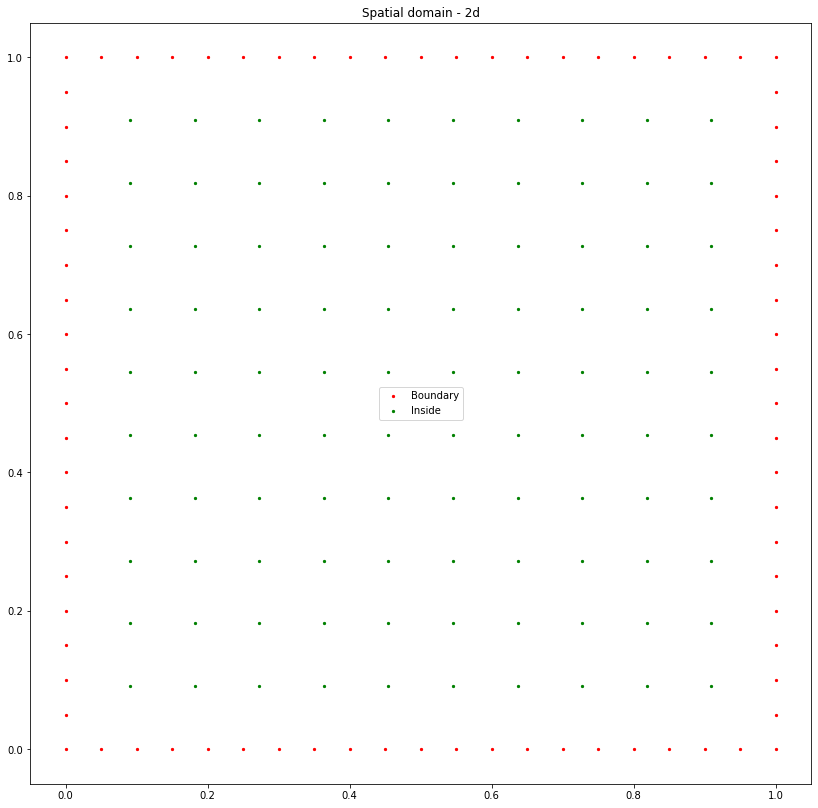

Number of points inside the domain: 100
Number of points at the boundary: 80


In [8]:
path = './Images/domain.png'
utils.plot_2d_domain(XY_inside, XY_bound, path)
print(f"Number of points inside the domain: {XY_inside.shape[0]}")
print(f"Number of points at the boundary: {XY_bound.shape[0]}")


# Model initialization

In [9]:
key = jax.random.PRNGKey(parameters['seed'])
NN_MLP = MLP(key, parameters['layers'])                 
params = NN_MLP.MLP_create()            # Create the MLP
NN_eval = NN_MLP.NN_evaluation            # Evaluation function
solver = PINN(NN_eval, parameters['optimizer'])
opt_state = parameters['optimizer'].init(params)

# Training

In [10]:
loss_history = []
loss_residual = []               # residual loss
loss_boundary = []               # boundary loss

print("Training start")
if parameters['options'] == 1:            # start a new training
    # Main loop to solve the PDE
    for ibatch in range(parameters['maximum_num_epochs']+1):

        loss, params, opt_state, losses = solver.train_step(params,opt_state, XY_inside, XY_bound, XY_bound_values)

        loss_residual.append(float(losses[0]))
        loss_boundary.append(float(losses[1]))
        losssum = jax.numpy.sum(losses)
        loss_history.append(float(losssum))

        if ibatch%parameters['report_steps']==parameters['report_steps']-1:
            print("Epoch n°{}: ".format(ibatch+1), losssum.item())

        if losssum<=numpy.min(loss_history): # save if the current state is the best 
            pickle.dump(params, open("./Checkpoints/params_pde8", "wb"))
            pickle.dump(opt_state, open("./Checkpoints/opt_state_pde8", "wb"))
            pickle.dump(loss_history, open("./Checkpoints/loss_history_pde8", "wb"))
            pickle.dump(loss_residual, open("./Checkpoints/loss_residual_pde8", "wb"))
            pickle.dump(loss_boundary, open("./Checkpoints/loss_boundary_pde8", "wb"))

        
elif parameters['options'] == 2:      # continue the last training
    params = pickle.load(open("./Checkpoints/params_pde8", "rb"))
    opt_state = pickle.load(open("./Checkpoints/opt_state_pde8", "rb"))
    loss_history = pickle.load(open("./Checkpoints/loss_history_pde8", "rb"))
    loss_residual = pickle.load(open("./Checkpoints/loss_residual_pde8", "rb"))
    loss_boundary = pickle.load(open("./Checkpoints/loss_boundary_pde8", "rb"))
    iepoch = len(loss_history)
    
    # Main loop to solve the PDE
    for ibatch in range(iepoch, parameters['maximum_num_epochs']+1):

        loss, params, opt_state, losses = solver.train_step(params,opt_state, XY_inside, XY_bound, XY_bound_values)

        loss_residual.append(float(losses[0]))
        loss_boundary.append(float(losses[1]))
        losssum = jax.numpy.sum(losses)
        loss_history.append(float(losssum))

        if ibatch%parameters['report_steps']==parameters['report_steps']-1:
            print("Epoch n°{}: ".format(ibatch+1), losssum.item())

        if losssum<=numpy.min(loss_history): # save if the current state is the best 
            pickle.dump(params, open("./Checkpoints/params_pde8", "wb"))
            pickle.dump(opt_state, open("./Checkpoints/opt_state_pde8", "wb"))
            pickle.dump(loss_history, open("./Checkpoints/loss_history_pde8", "wb"))
            pickle.dump(loss_residual, open("./Checkpoints/loss_residual_pde8", "wb"))
            pickle.dump(loss_boundary, open("./Checkpoints/loss_boundary_pde8", "wb"))

else:
    params = pickle.load(open("./Checkpoints/params_pde8", "rb"))
    opt_state = pickle.load(open("./Checkpoints/opt_state_pde8", "rb"))
    loss_history = pickle.load(open("./Checkpoints/loss_history_pde8", "rb"))
    loss_residual = pickle.load(open("./Checkpoints/loss_residual_pde8", "rb"))
    loss_boundary = pickle.load(open("./Checkpoints/loss_boundary_pde8", "rb"))


Training start
Epoch n°1000:  0.004318969441311331
Epoch n°2000:  0.008391406635529421
Epoch n°3000:  0.0010234785258392395
Epoch n°4000:  0.0038726416136400923
Epoch n°5000:  0.0007853094088565584
Epoch n°6000:  0.00044357989670817846
Epoch n°7000:  0.0004346539119934826
Epoch n°8000:  0.0004214430161506781
Epoch n°9000:  0.00040251627994937266
Epoch n°10000:  0.00037635222310415103
Epoch n°11000:  0.00034208771063102357
Epoch n°12000:  0.0003011497012136674
Epoch n°13000:  0.00025812346716981306
Epoch n°14000:  0.0002172362834933412
Epoch n°15000:  0.00017792830499324197
Epoch n°16000:  0.00013834606587564545
Epoch n°17000:  0.00010211649431593482
Epoch n°18000:  7.846663214160788e-05
Epoch n°19000:  6.349700700878646e-05
Epoch n°20000:  5.311659305434744e-05
Epoch n°21000:  4.551406283002082e-05
Epoch n°22000:  3.979238831485529e-05
Epoch n°23000:  3.520319699363682e-05
Epoch n°24000:  3.149822983371315e-05
Epoch n°25000:  2.8512405486068815e-05
Epoch n°26000:  2.5745052073287436e-0

# Loss function plot

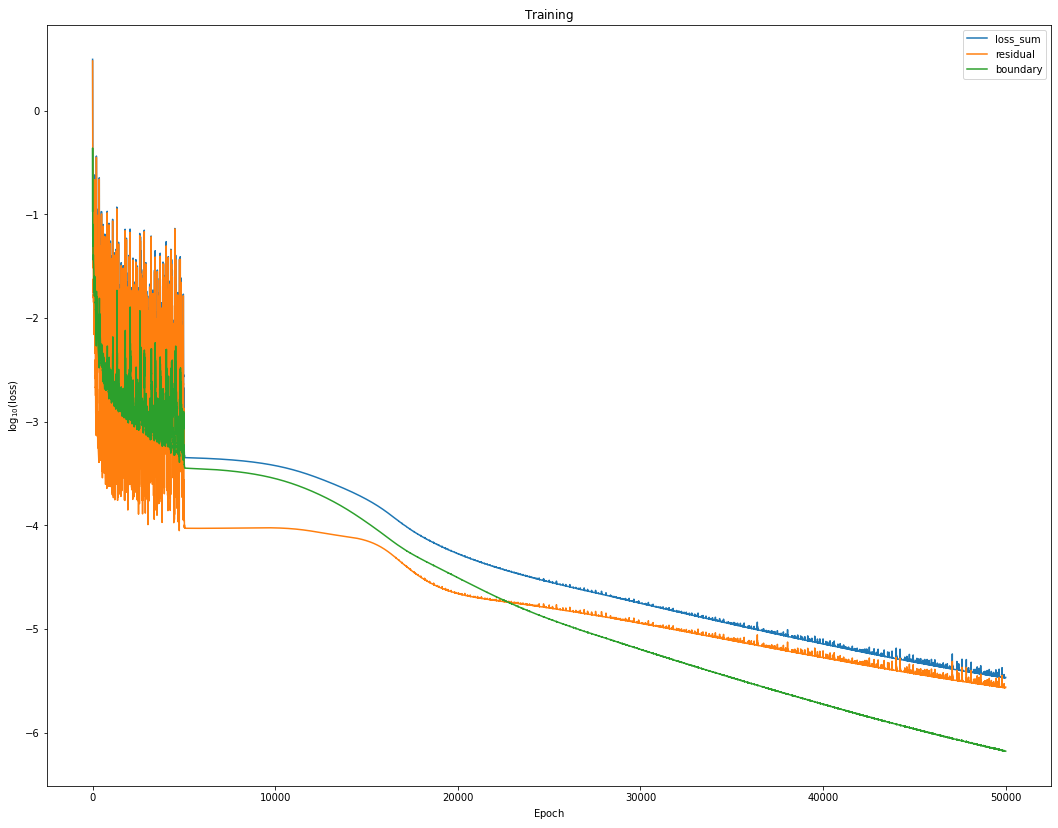

In [11]:
path = './Images/loss_function.png'
losses = [loss_history, loss_residual, loss_boundary]
utils.plot_loss_history(losses, path)

# Load best params of the training

In [12]:
params = pickle.load(open("./Checkpoints/params_pde8", "rb"))

# Approximated solution plot

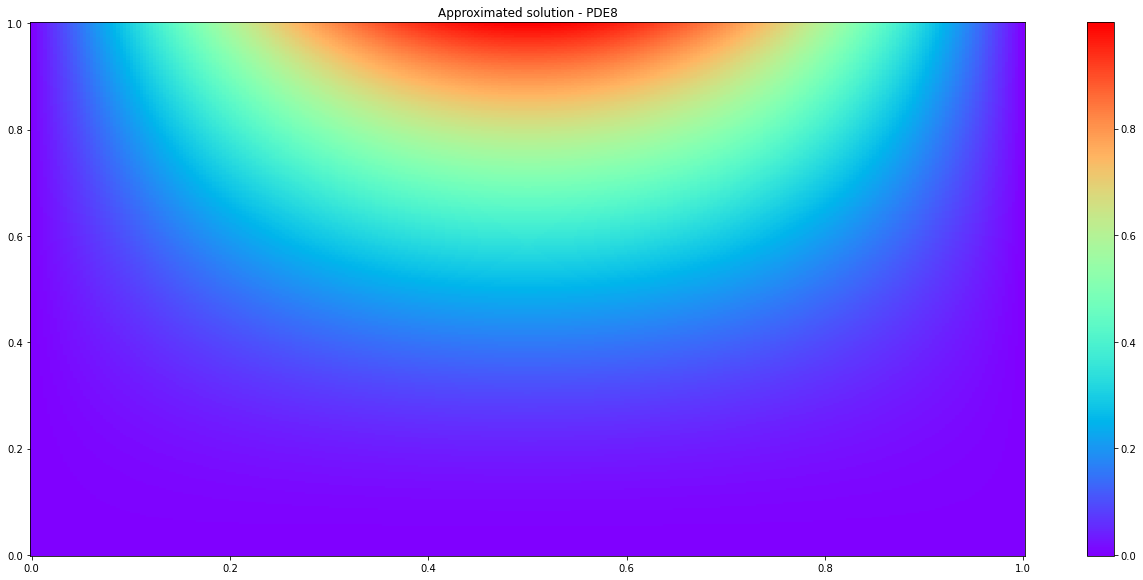

In [16]:
path = './Images/approximated_pde8.png'
title = 'Approximated solution - PDE8'
spatial_solution2d = lambda params, x, y: solver.spatial_solution2d(params, x, y)[:, 0]
_ = utils.plot_2d_colormesh(params, parameters['domain_bounds'], spatial_solution2d, parameters['domain_bounds'], path, title)

# Analytical solution plot

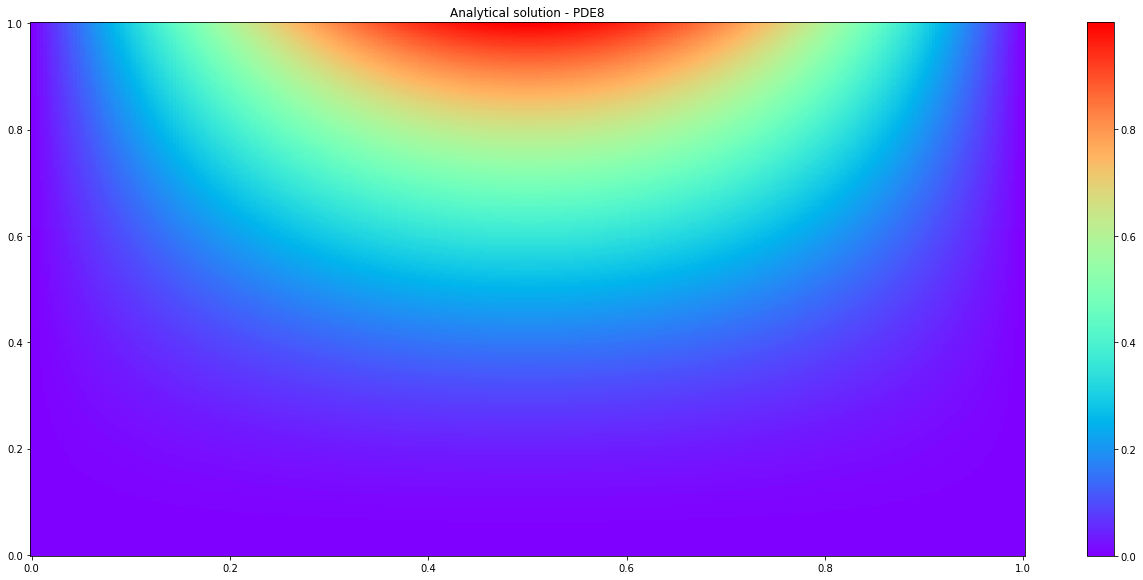

In [17]:
path = './Images/approximated_pde8.png'
title = 'Analytical solution - PDE8'
analytical = lambda params, x, y: analytical_solution(x, y)
_ = utils.plot_2d_colormesh(params, parameters['domain_bounds'], analytical, parameters['domain_bounds'], path, title)

# Squared error plot

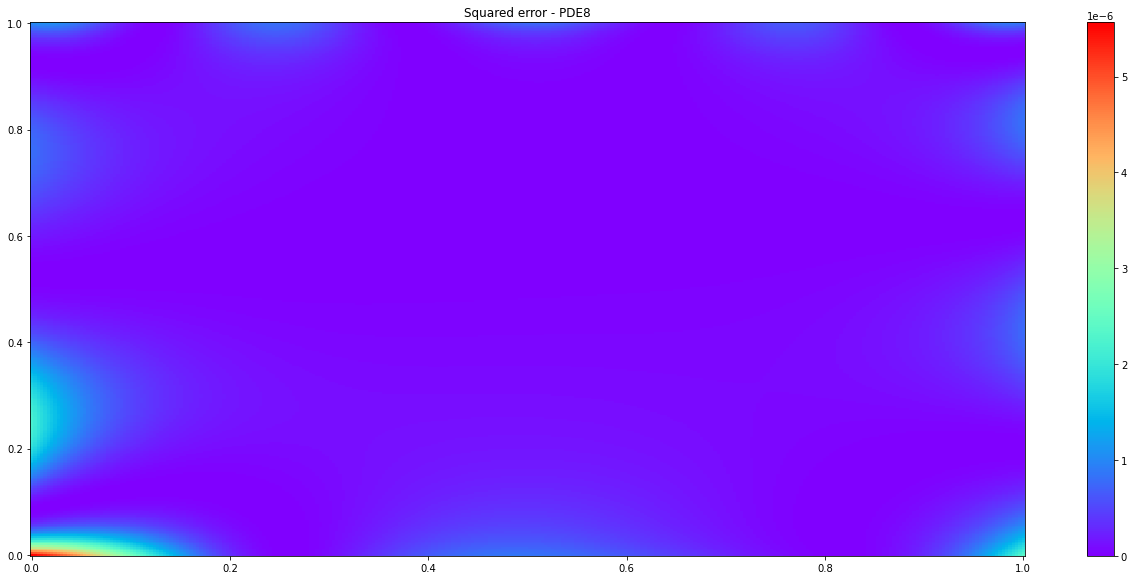

MSE:  1.4840100949993908e-07


In [15]:
path = './Images/squared_error_pde8.png'
title = 'Squared error - PDE8'
squared_error = lambda params, x, y: (solver.spatial_solution2d(params, x ,y)[:,0] - analytical_solution(x, y))**2
mse = utils.plot_2d_colormesh(params, parameters['domain_bounds'], squared_error, parameters['domain_bounds'], path, title)
print("MSE: ", mse)